## Def functions

In [1]:
def curl(gstep, vector):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector
    
    def dAdx(A):
        return np.gradient(A, axis = 0) / gstep[0]
    def dAdy(A):
        return np.gradient(A, axis = 1) / gstep[1]
    def dAdz(A):
        return np.gradient(A, axis = 2) / gstep[2]
    
    Cx = dAdy(Az) - dAdz(Ay)
    Cy = dAdz(Ax) - dAdx(Az)
    Cz = dAdx(Ay) - dAdy(Ax)
    
    return [Cx, Cy, Cz]

def dot_product(vector_1, vector_2):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector_1
    Bx, By, Bz = vector_2
    
    return Ax[:]*Bx[:] + Ay[:]*By[:] + Az[:]*Bz[:]

def cross_product(vector_1, vector_2):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector_1
    Bx, By, Bz = vector_2
    
    Cx = Ay * Bz - Az * Ay
    Cy = Az * Bx - Ax * Bz
    Cz = Ax * By - Ay * Bx
    
    return [Cx, Cy, Cz]
    

def norm(vector):
    """
    vector = [Ax, Ay, Az]
    """
    
    return np.sqrt(dot_product(vector, vector)[:])


## Import modules and functions

In [227]:
# # -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
from math import pi, sqrt

import pylab as pl
import matplotlib
from matplotlib.colors   import BoundaryNorm
from matplotlib.ticker   import MaxNLocator
from matplotlib.gridspec import GridSpec

from matplotlib import rcParams


import import_ipynb
import Module_Diagnostics as MD

from tempfile import mkdtemp
import os.path as path
import json

#import pdb
#pdb.set_trace()

## Choose run and time for analysis

In [3]:
Cluster = 'Zoidberg'
Cluster = 'Curie'
Cluster = 'Occ'
run_name = '20_05_18_event_only'

time = 210
time = '%05d' % time    # Change the time to string format, needed by functions

filepath = '../' + Cluster + '/' + run_name + '/ncfiles/'
date = re.search('w_(.+?)_t', glob.glob(filepath+'Magw*_t'+time+'.nc')[0]).group(1)

print(date)

18_05_20


## Get data in Magw, Hsw and Elew 

#### Clear local tmp folder

In [4]:
!rm -rf /tmp/*

rm: cannot remove '/tmp/snap.spotify': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-bolt.service-SBiHWc': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-colord.service-4VzCdM': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-fwupd.service-CuXuGu': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-ModemManager.service-SiO6WW': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-rtkit-daemon.service-vLfpVf': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-systemd-resolved.service-syXUel': Operation not permitted
rm: cannot remove '/tmp/systemd-private-e3bf04f6b7e441b89039108582a6c752-systemd-timesyncd.service-Tao5yK': Operation not permitted


### Download B, n, E, T, V

In [5]:
## Load B and X, Y, Z

# There might be some MemoryError. In that case, follow the guide:
# https://stackoverflow.com/questions/60563936/memoryerror-unable-to-allocate-3-78-gib-for-an-array-with-shape-802-842-1502
Magw = MD.import_data_3D(filepath, date, time, 'Magw')

x = np.array(np.around(Magw['x']))
y = np.array(np.around(Magw['y']))
z = np.array(np.around(Magw['z']))

cwp = Magw['c_omegapi']
gstep = Magw['gstep']

nx,  ny,  nz  = len(x), len(y), len(z)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
nx0, ny0, nz0 = int(np.where(x==0)[0]), int(np.where(y==0)[0]), int(np.where(z==0)[0])
            
# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
file_Bx = path.join(mkdtemp(), 'Bx.dat')            
Bx = np.memmap(file_Bx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bx[:] = Magw['Bx']
file_By = path.join(mkdtemp(), 'By.dat')            
By = np.memmap(file_By, dtype='float32', mode='w+', shape=(nx,ny,nz))
By[:] = Magw['By']
file_Bz = path.join(mkdtemp(), 'Bz.dat')            
Bz = np.memmap(file_Bz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bz[:] = Magw['Bz']
del Magw
B = [Bx, By, Bz]

## Load N, Vxyz, and T
Hsw = MD.import_data_3D(filepath, date, time, 'Hsw')
# Density in nb/cm^3
file_N = path.join(mkdtemp(), 'N.dat')            
N = np.memmap(file_N, dtype='float32', mode='w+', shape=(nx,ny,nz))
N[:] = Hsw['n']
# Velocity in km/s
file_Vx = path.join(mkdtemp(), 'Vx.dat')            
Vx = np.memmap(file_Vx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vx[:] = Hsw['Vx']
file_Vy = path.join(mkdtemp(), 'Vy.dat')            
Vy = np.memmap(file_Vy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vy[:] = Hsw['Vy']
file_Vz = path.join(mkdtemp(), 'Vz.dat')            
Vz = np.memmap(file_Vz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vz[:] = Hsw['Vz']
# Temperature in eV
file_T = path.join(mkdtemp(), 'T.dat')            
T = np.memmap(file_T, dtype='float32', mode='w+', shape=(nx,ny,nz))
T[:] = Hsw['T']
del Hsw
V = [Vx, Vy, Vz]

## Load E
# Electric field in mV/m
Elew = MD.import_data_3D(filepath, date, time, 'Elew')
file_Ex = path.join(mkdtemp(), 'Ex.dat')            
Ex = np.memmap(file_Ex, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ex[:] = Elew['Ex']*1e6
file_Ey = path.join(mkdtemp(), 'Ey.dat')            
Ey = np.memmap(file_Ey, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ey[:] = Elew['Ey']*1e6
file_Ez = path.join(mkdtemp(), 'Ez.dat')            
Ez = np.memmap(file_Ez, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ez[:] = Elew['Ez']*1e6
del Elew
E = [Ex, Ey, Ez]

Importing Magw 3D from ../Occ/20_05_18_event_only/ncfiles/
Reading Bx...
Reading By...
Reading Bz...
Close file and return...
Importing Hsw 3D from ../Occ/20_05_18_event_only/ncfiles/
Reading density...
Reading Ux...
Reading Uy...
Reading Uz...
Reading T...
Close file and return...
Importing Elew 3D from ../Occ/20_05_18_event_only/ncfiles/
Reading Ex...
Reading Ey...
Reading Ez...
Close file and return...


## Physics constants & Normalisation

In [6]:
qe = 1.60217662e-19 #C

In [7]:
b = 1e-9
j = 1e-9
v = 1e3
e = 1e3
n = 1e6

### Compute J

In [8]:
gstep_bis = np.mean(x[1:]-x[:-1])

file_Jx = path.join(mkdtemp(), 'Jx.dat')        
Jx = np.memmap(file_Jx, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_Jy = path.join(mkdtemp(), 'Jy.dat')     
Jy = np.memmap(file_Jy, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_Jz = path.join(mkdtemp(), 'Jz.dat') 
Jz = np.memmap(file_Jz, dtype='float32', mode='w+', shape=(nx,ny,nz))
     
Jx[:], Jy[:], Jz[:] = MD.J(B)
           
J = [Jx, Jy, Jz]

## Plot parametering

In [9]:
# %matplotlib notebook

## Playground

### Ohm's law

$$ E = - v_i \times B + \frac{j \times B}{n_e q_e} - \frac{\nabla \cdot P_e}{n_e q_e}$$

In [10]:
file_VxBx = path.join(mkdtemp(), 'VxBx.dat')        
VxBx = np.memmap(file_VxBx, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_VxBy = path.join(mkdtemp(), 'VxBy.dat')     
VxBy = np.memmap(file_VxBy, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_VxBz = path.join(mkdtemp(), 'VxBz.dat') 
VxBz = np.memmap(file_VxBz, dtype='float32', mode='w+', shape=(nx,ny,nz))

VxBx[:], VxBy[:], VxBz[:] = cross_product(V, B)
VxB = [VxBx, VxBy, VxBz]

file_JxBx = path.join(mkdtemp(), 'JxBx.dat')        
JxBx = np.memmap(file_JxBx, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_JxBy = path.join(mkdtemp(), 'JxBy.dat')     
JxBy = np.memmap(file_JxBy, dtype='float32', mode='w+', shape=(nx,ny,nz))
file_JxBz = path.join(mkdtemp(), 'JxBz.dat') 
JxBz = np.memmap(file_JxBz, dtype='float32', mode='w+', shape=(nx,ny,nz))

JxBx[:], JxBy[:], JxBz[:] = cross_product(J, B)[:]
JxB = [JxBx, JxBy, JxBz]

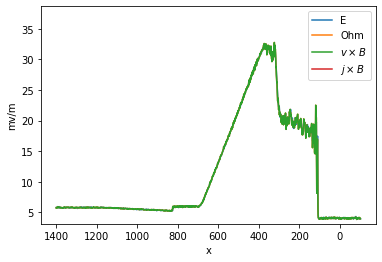

In [11]:
# plt.plot(X, E[2][:, ny0, nz0], label='Ez')
# plt.plot(X, -1e3*b*v*VxB[2][:, ny0, nz0], label='(VxB)z')
# plt.plot(X, 1e3*j*b*JxB[2][:, ny0, nz0], label='(JxB)z')
# plt.xlabel('x')
# plt.xlim([200,400])
# # plt.xlim([400,800])
# plt.ylabel('mv/m')
# plt.gca().invert_xaxis()

# plt.legend()
# plt.show()

i = 2
Ohm = -v*b*VxB[i][:, ny0, nz0] + j*b*JxB[i][:, ny0, nz0]/n
plt.plot(x, E[i][:, ny0, nz0], label='E')
plt.plot(x, 1e3*Ohm, label='Ohm')
plt.plot(x, 1e3*(-b*v*VxB[i][:, ny0, nz0]), label=r'$v \times B$')
plt.plot(x, 1e3*(j*b*JxB[i][:, ny0, nz0]/n), label=r'$j \times B$')
plt.xlabel('x')
# plt.xlim([200,800])
mini = np.nanmin(E[i][:, ny0, nz0])*0.8
maxi = np.nanmax(E[i][:, ny0, nz0])*1.2
plt.ylim([mini, maxi])
plt.ylabel('mv/m')
plt.gca().invert_xaxis()
plt.legend()
plt.show()



### Why Vz?

In [356]:
x_slice = slice(30,380)
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A):
    return np.mean(A[slices_2], axis=(1,2))

#### Ohm's law

##### Preliminary computations & definitions

In [357]:
ne = np.array(N[:])
Te = np.mean(T[50:150, ny0, nz0]) * (ne/6)**(2/3) #eV

In [358]:
np.mean(T[50:150, ny0, nz0])

18.331894

In [359]:
np.mean(Te)

20.728218

In [360]:
Pe = (3/2)*MD.kB*np.array(ne*n*Te*MD.t)

In [361]:
i = 0

In [362]:
advection = -b*v*MD.cross_product(V, B, slice_=slices)[i]
advection = np.mean(advection, axis=(1,2))

Hall = j*b/n*MD.cross_product(J, B, slice_=slices)[i] * (1/(qe*N[slices]))
Hall = np.mean(Hall, axis=(1,2))

pressure = - (np.gradient(Pe)/(cwp*1e3) / (qe*N*n)) [i][x_slice, ny0, nz0]

Ohm = advection + Hall + pressure 

In [363]:
advection_2 = -b*v*MD.cross_product(V, B, slice_=slices_2)[i]
advection_2 = np.mean(advection_2, axis=(1,2))

Hall_2 = j*b/n*MD.cross_product(J, B, slice_=slices_2)[i] * (1/(qe*N[slices_2]))
Hall_2 = np.mean(Hall_2, axis=(1,2))

pressure_2 = - (np.gradient(Pe)/(cwp*1e3) / (qe*N*n)) [i][slices_2]
pressure_2 = np.mean(pressure_2, axis=(1,2))

Ohm_2 = advection_2 + Hall_2 + pressure_2

##### Plots

(130.0, 100.0)

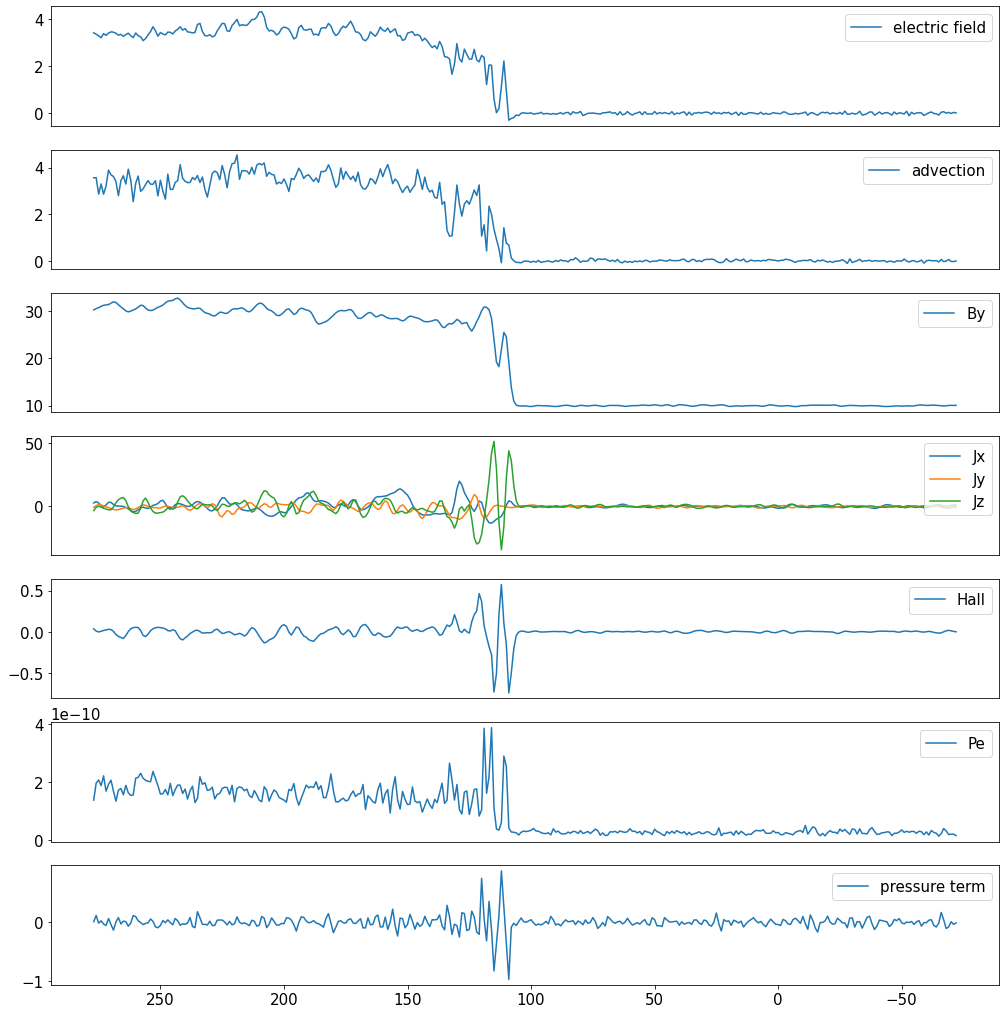

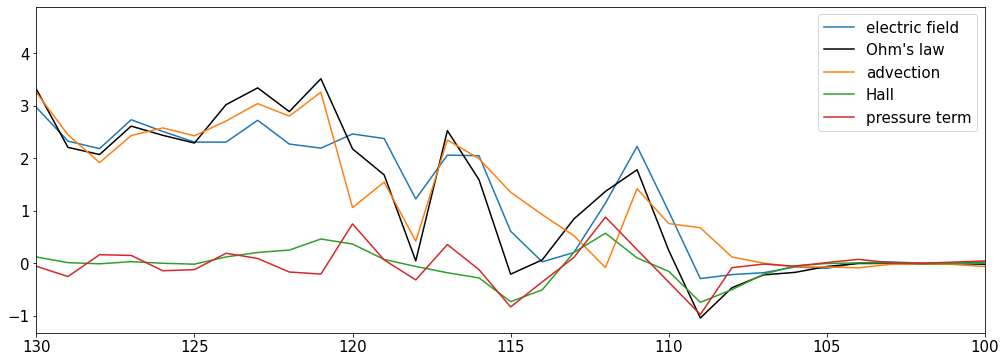

In [375]:
rcParams["figure.figsize"] = [17, 18]

gs = GridSpec(7, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], Ex[x_slice, ny0, nz0], label='electric field')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], e*advection, label='advection')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], By[x_slice, ny0, nz0], label='By')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[x_slice], np.mean(MD.Jx(B, slices), axis=(1,2)), label='Jx')
plt.plot(x[x_slice], np.mean(MD.Jy(B, slices), axis=(1,2)), label='Jy')
plt.plot(x[x_slice], np.mean(MD.Jz(B, slices), axis=(1,2)), label='Jz')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[4], sharex=axe)
plt.plot(x[x_slice], e*Hall, label='Hall')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[5], sharex=axe)
plt.plot(x[x_slice], Pe[x_slice, ny0, nz0], label='Pe')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[6], sharex=axe)
plt.plot(x[x_slice], e*pressure, label='pressure term')
plt.legend()

plt.gca().invert_xaxis()

rcParams["figure.figsize"] = [17, 6]
plt.figure()
plt.plot(x[x_slice], E[i][x_slice, ny0, nz0], label='electric field')
plt.plot(x[x_slice], e*Ohm, label="Ohm's law", color="black")
plt.plot(x[x_slice], e*advection, label='advection')
plt.plot(x[x_slice], e*Hall, label='Hall')
plt.plot(x[x_slice], e*pressure, label='pressure term')
plt.legend(loc='upper right')

plt.xlim([130,100])

(130.0, 100.0)

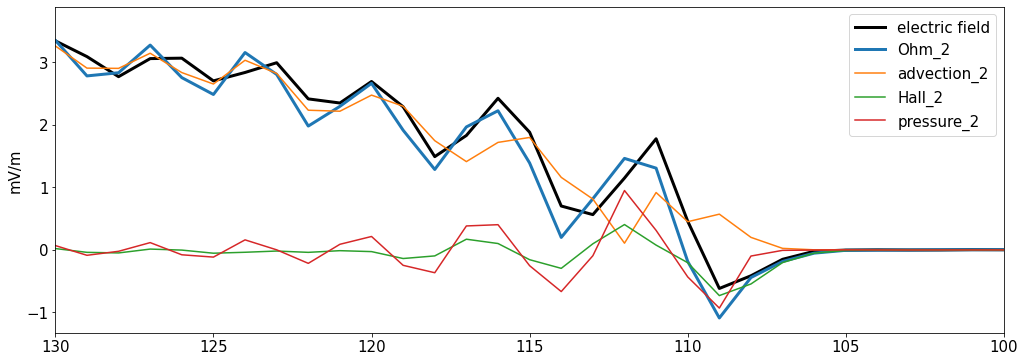

In [381]:
rcParams["figure.figsize"] = [17, 6]
plt.figure()
plt.plot(x[x_slice], np.mean(E[i][slices_2], axis=(1,2)), label='electric field', color='black', linewidth=3)
plt.plot(x[x_slice], e*Ohm_2, label='Ohm_2', linewidth=3)
plt.plot(x[x_slice], e*advection_2, label='advection_2')
plt.plot(x[x_slice], e*Hall_2, label='Hall_2')
plt.plot(x[x_slice], e*pressure_2, label='pressure_2')
plt.legend(loc='upper right')
plt.ylabel('mV/m')

plt.xlim([130,100])

(130.0, 100.0)

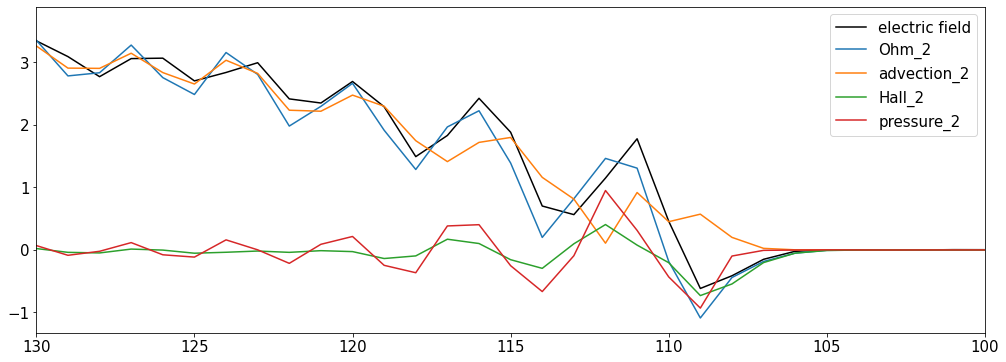

In [368]:
rcParams["figure.figsize"] = [17, 6]
plt.figure()
plt.plot(x[x_slice], smooth(E[i]), label='electric field', color='black')
plt.plot(x[x_slice], e*Ohm_2, label='Ohm_2')
plt.plot(x[x_slice], e*advection_2, label='advection_2')
plt.plot(x[x_slice], e*Hall_2, label='Hall_2')
plt.plot(x[x_slice], e*pressure_2, label='pressure_2')
plt.legend(loc='upper right')

plt.xlim([130,100])

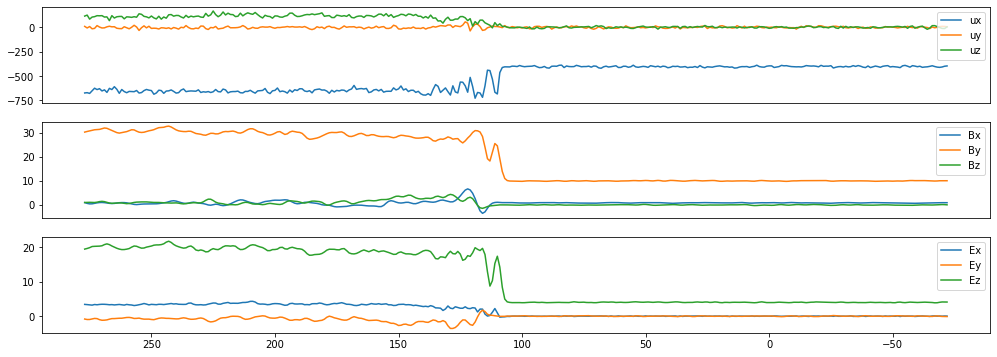

In [174]:
gs = GridSpec(3, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], V[0][x_slice, ny0, nz0], label='ux')
plt.plot(x[x_slice], V[1][x_slice, ny0, nz0], label='uy')
plt.plot(x[x_slice], V[2][x_slice, ny0, nz0], label='uz')
plt.legend(loc = 'upper right')
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], B[0][x_slice, ny0, nz0], label='Bx')
plt.plot(x[x_slice], B[1][x_slice, ny0, nz0], label='By')
plt.plot(x[x_slice], B[2][x_slice, ny0, nz0], label='Bz')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], E[0][x_slice, ny0, nz0], label='Ex')
plt.plot(x[x_slice], E[1][x_slice, ny0, nz0], label='Ey')
plt.plot(x[x_slice], E[2][x_slice, ny0, nz0], label='Ez')
plt.legend()

plt.gca().invert_xaxis()

#### Rankine-Hugoniot

##### Move to the Hoffmann-Teller frame

In [245]:
shock_position = 110 #Ugly hard code
i_shock_position = np.where(x==shock_position)[0][0]

upstream_slice   = slice(i_shock_position-80,i_shock_position-30)
downstream_slice = slice(i_shock_position+30,i_shock_position+80)

In [247]:
x_slice = slice(i_shock_position-100,i_shock_position+100)
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A):
    return np.mean(A[slices_2], axis=(1,2))

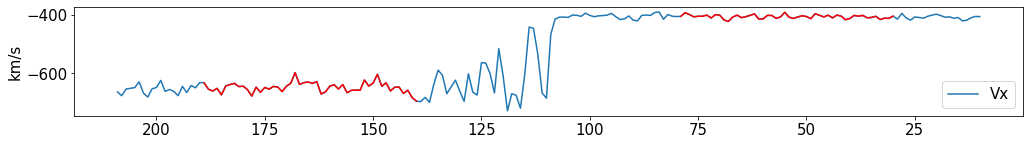

In [274]:
rcParams["figure.figsize"] = [17, 2]

plt.plot(x[x_slice], Vx[x_slice, ny0, nz0], label="Vx")
plt.plot(x[upstream_slice  ], Vx[upstream_slice, ny0, nz0], color="red")
plt.plot(x[downstream_slice], Vx[downstream_slice, ny0, nz0], color="red")
plt.ylabel('km/s')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()

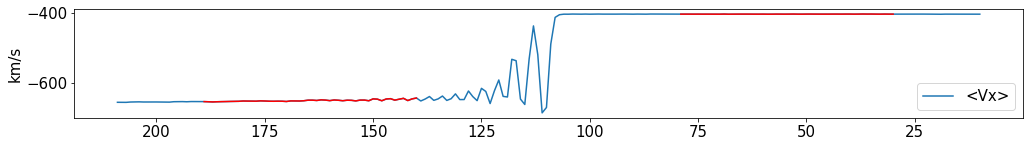

In [276]:
rcParams["figure.figsize"] = [17, 2]

plt.plot(x[x_slice], smooth(Vx), label="<Vx>")
plt.plot(x[upstream_slice  ], np.mean(Vx[upstream_slice  , y_slice_2, z_slice_2], axis=(1,2)), color="red")
plt.plot(x[downstream_slice], np.mean(Vx[downstream_slice, y_slice_2, z_slice_2], axis=(1,2)), color="red")
plt.ylabel('km/s')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()

In [250]:
v_up = np.nanmean(Vx[upstream_slice, y_slice_2, z_slice_2])
print(f"v_upstream = {v_up:0.0f} km/s")

v_down = np.nanmean(Vx[downstream_slice, y_slice_2, z_slice_2])
print(f"v_downstream = {v_down:0.0f} km/s")

n_up = np.nanmean(N[upstream_slice, y_slice_2, z_slice_2])
print(f"n_upstream = {n_up:0.0f} ions/cm^3")

n_down = np.nanmean(N[downstream_slice, y_slice_2, z_slice_2])
print(f"n_downstream = {n_down:0.0f} ions/cm^3")

v_upstream = -403 km/s
v_downstream = -651 km/s
n_upstream = 6 ions/cm^3
n_downstream = 17 ions/cm^3


In [251]:
V_HF = (n_up*v_up - n_down*v_down)/(n_up - n_down)

print(f'V_Hoffman-Teller = {V_HF:0.0f} km/s')

V_Hoffman-Teller = -781 km/s


In [252]:
Vx_hf = Vx - V_HF

##### Rankine Hugoniot

\begin{equation}
\begin{split}
    \text{Absence of magnetic monopoles:} \ \ \ \ & \left[ B_n \right] = 0 \\
    \text{Continuity equation:} \ \ \ \ & \left[ \rho u_n \right] = 0 \\
    \text{Maxwell-Faraday:} \ \ \ \ & \left[ u_n B_{t1} - u_{t1} B_n \right] = 0 \ \ \ \& \ \ \ \left[ u_n B_{t2} - u_{t2} B_n \right] = 0 \\
    \text{Equation of motion:} \ \ \ \ & \left[ \frac{1}{2}\rho u_n \vec{u} + (P_\text{th} + \frac{B^2}{2 \mu_0}) \vec{e}_n - \frac{B_n \vec{B}}{\mu_0} \right] = 0 \\
\end{split}
\end{equation}

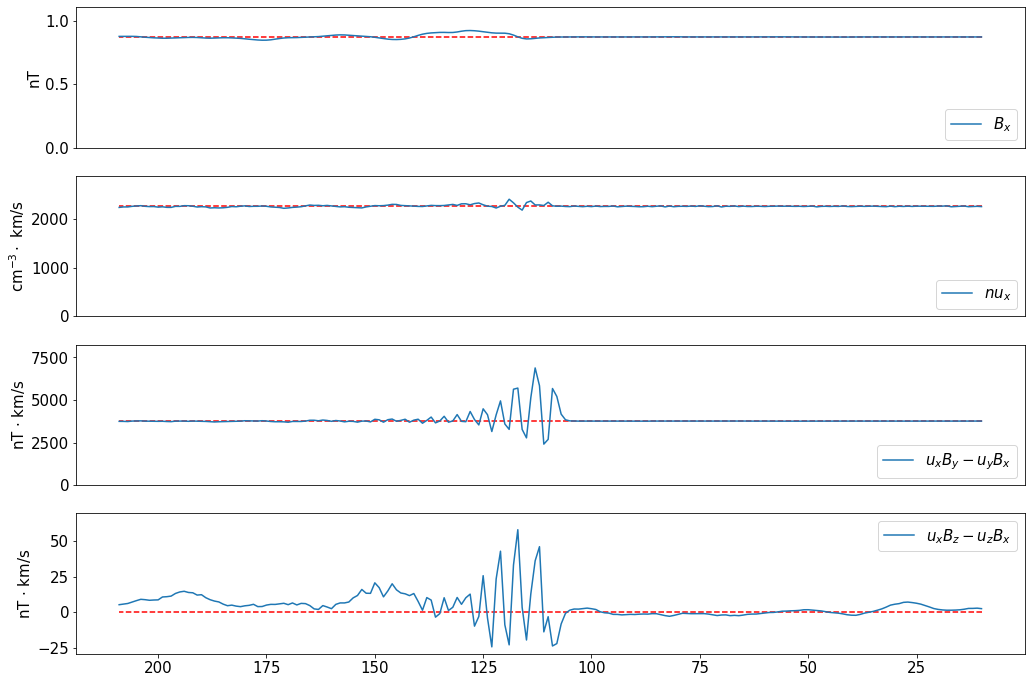

In [293]:
n_plots = 5

rcParams["figure.figsize"] = [17, n_plots*3]
matplotlib.rcParams.update({'font.size': 15})

gs = GridSpec(n_plots, 1)

data = smooth(Bx)
axe = plt.subplot(gs[0])
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean(Bx[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")

plt.plot(x[x_slice], smooth(Bx), label=r'$B_x$')
plt.legend(loc='lower right')
plt.ylabel("nT")
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])

data = smooth(N*Vx_hf)
axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((N*Vx_hf)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$n u_x$')
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3} \cdot$ km/s')
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])

data = smooth(Vx_hf*By - Vy*Bx)
axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((Vx_hf*By - Vy*Bx)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$u_x B_{y} - u_{y} B_x$')
plt.legend(loc='lower right')
plt.ylabel(r"nT $\cdot$ km/s")
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])

data = smooth(Vx_hf*Bz - Vz*Bx)
axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((Vx_hf*Bz - Vz*Bx)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$u_x B_{z} - u_{z} B_x$')
plt.legend(loc='upper right')
plt.ylabel(r"nT $\cdot$ km/s")
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])


# rcParams["figure.figsize"] = [17, 4]
# plt.figure()
# axe = plt.subplot(sharex=axe)
# plt.plot(x[x_slice], smooth(  (1/2)*MD.mp*N*n*(v*Vx_hf)**2 \
#                             + MD.kB*N*n*T*MD.t       \
#                             + (MD.norm(B)*b)**2/(2*MD.µ0) - (b*Bx)**2/MD.µ0) \
# , label=r'$ \frac{1}{2}\rho u_n \vec{u} + (P_{th} + \frac{B^2}{2 \mu_0}) \vec{e}_n - \frac{B_n \vec{B}}{\mu_0}$')
# plt.plot(x[x_slice], smooth((1/2)*MD.mp*N*n*(v*Vx_hf)**2), label='Pdyn')
# plt.plot(x[x_slice], smooth(MD.kB*N*n*T*MD.t), label='Pth')
# plt.plot(x[x_slice], smooth((MD.norm(B)*b)**2/(2*MD.µ0) - (b*Bx)**2/MD.µ0), label='Pmag')  # - (b*Bx)**2/MD.µ0
# plt.legend(loc='upper right')
# axe.set_ylim(bottom=0)

plt.gca().invert_xaxis()
